### Load Modules

In [1]:
#pip install dill matplotlib ptitprince pandas sympy

In [2]:
# Standard Library Imports
import os

# Serialization Library
import dill as pickle

# Change Current Directory
current_dir = '../../../'
os.chdir(current_dir)
current_working_directory = os.getcwd()

# Basic and Utility Imports from Local Modules
from src.codes.basic import *
from src.codes.utils.fem_utils_HC import *
from src.codes.utils.plot_files.plot_utils import OneDPlot as plot
from src.codes.utils.rom_utils import *
# from src.codes.utils.plot_utils import data_stats

# # Problem Classes for Heat Conduction
from src.codes.prob_classes.heat_conduction.base_class_heat_conduction import FOS_FEM, probdata, ROM_simulation

os.chdir(current_dir)
# # Reduced Order Modeling (ROM) Classes
import src.codes.reductor.rom_class_ms as rom_class

# Algorithms for ECSW Model Reduction
# from src.codes.algorithms.ecsw_ms import ecsw_red_ms
from src.codes.algorithms.ecsw_test import ecsw_red

# Third-Party Libraries for Data Handling and Visualization
import ptitprince as pt
import pandas as pd

os.chdir(current_working_directory)

# Reload Specific Modules (Uncomment if needed)
# from importlib import reload
# reload(deim_module)

In [3]:
current_working_directory

'c:\\Users\\suparnob\\OneDrive - Texas A&M University\\Academic\\TAMU_MATERIALS\\POSTDOC\\HYPERREDUCTION\\SUPARNO\\HYPERREDUCTION__TAMIDS\\pyHyperRom'

### Load data

In [4]:
#%run examples/heat_conduction/OneD_heat_conduction/FEM_1D_data_gen.py

In [5]:
filename_dataC = 'examples/heat_conduction/OneD_heat_conduction/data/DataClass_UQ_NL_new.dill'
with open(filename_dataC, 'rb') as f:
    Data_cls = pickle.load(f)

# load required variables from data
FOS = Data_cls.FOS
d = FOS.data
param_list = np.asarray(Data_cls.param_list)
NLS = np.asarray(Data_cls.NL_solutions)
K_mus = Data_cls.K_mus
q_mus = Data_cls.q_mus
train_mask, test_mask = Data_cls.train_mask, Data_cls.test_mask 

N_snap,_ = np.shape(NLS)
print(N_snap)

100


### Plot data

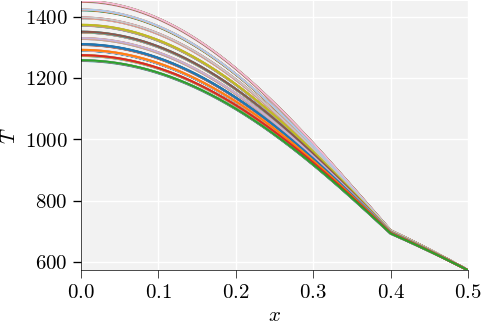

In [6]:
fig, ax = plt.subplots(figsize=(5,3.5))

for i in range(N_snap):
    Plot = plot(d.xi[0], NLS[i], ax=ax)
    Plot.line_()
plt.show()

## ECSW Hyper-reduction

### Train-Test split

In [7]:
# You may choose to define you train and test set data too!
# train_mask, test_mask = train_test_split(N_snap)

NLS_train = NLS[train_mask][:,d.mask]
param_list_train = param_list[train_mask]

NLS_test = NLS[test_mask][:,d.mask]

### Mean Subtraction

In [8]:
NLS_train_mean = np.mean(NLS_train,axis=0)
NLS_train_mean.shape
NLS_train_ms = NLS_train - NLS_train_mean

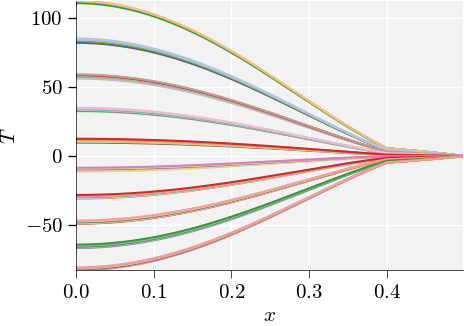

In [9]:
fig, ax = plt.subplots(figsize=(5,3.5))

for i in range(80):
    Plot = plot(d.xi[0][d.mask], NLS_train_ms[i], ax=ax)
    Plot.line_()
plt.show()


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

Number of modes selected: 2


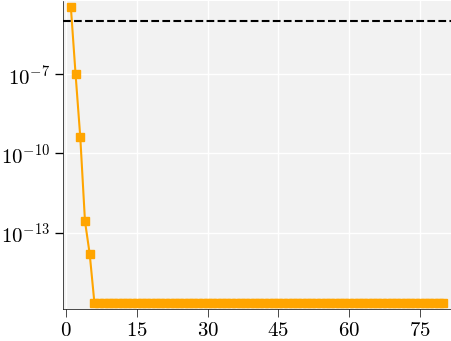

In [10]:
# plt.rcParams['figure.dpi'] = 100
n_sel, U = svd_mode_selector(NLS_train_ms, tolerance=1e-5,modes=True)
V_sel = U[:, :n_sel]

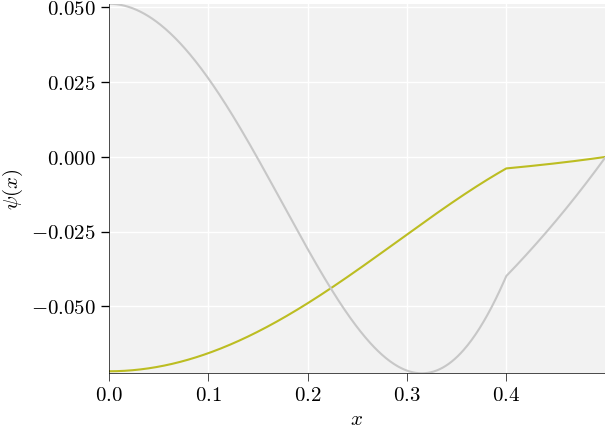

In [11]:
fig, ax = plt.subplots()

for i in range(n_sel):
    Plot = plot(d.xi[0][d.mask], V_sel[:,i], ax=ax)
    Plot.line_()
    
Plot.ax.set_xlabel('$x$')
Plot.ax.set_ylabel('$\psi(x)$')

plt.show()

### Step 2: Perform NNLS for ECSW

In [12]:
def NNLS_ECSW_SVD(UU, SIG, VV, d_vec):
    tol = 1e-8
    # d_vec = C @ np.ones((ncells, 1))
    norm_d_vec = np.linalg.norm(d_vec)
    print(f"norm of rhs: {norm_d_vec}")

    d_vec_m = np.linalg.pinv(np.diag(SIG))@UU.T@d_vec

    C = VV

    if tol is None:
        x, residual = nnls(C, d_vec_m.flatten(), maxiter=1e6)
    else:
        x, residual = nnls_sp(C, d_vec_m.flatten(), atol=tol, maxiter=1e6)

    return x, residual, norm_d_vec

In [13]:
tic_h_setup_b = time.time()

N_snap_train,_ = np.shape(NLS_train)
tol = 1e-8

# xi, residual = ecsw_red_ms(d, V_sel, d.Le, K_mus, q_mus, n_sel, N_snap_train, d.mask, NLS_train_ms, NLS_train_mean, tol=tol)

data = {'K_mus':K_mus,'q_mus':q_mus}
_, _,C_matrix, d_vec, time_nnls = ecsw_red(d, V_sel, d.Le, data, n_sel, N_snap_train, NLS_train_ms, NLS_train_mean, Data_cls.FOS.residual_func, tol=tol)


toc_h_setup_b = time.time()

norm of rhs: 720.6208557877734


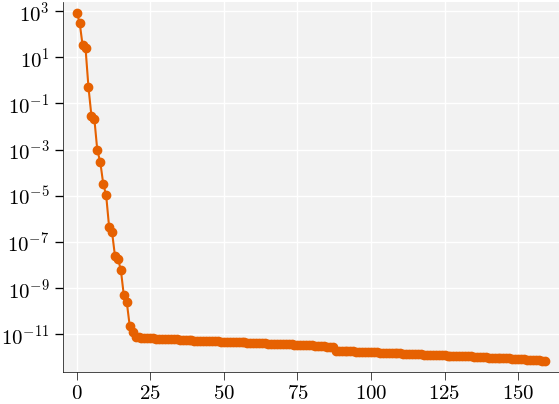

In [14]:
[UU,SIG,VV] = np.linalg.svd(C_matrix, full_matrices=True)
plt.semilogy(SIG,'o-')

In [15]:
mm = 10
C_app = (UU[:,:mm]*SIG[:mm])@VV[:mm,:]
np.linalg.norm(C_app-C_matrix)

1.0600630556343722e-05

In [16]:
from src.codes.algorithms.nnls_scipy import nnls as nnls_sp
from scipy.optimize import nnls

tic_h_setup_svd = time.time()

xi, residual, norm_d_vec = NNLS_ECSW_SVD(UU[:,:mm],SIG[:mm], VV[:mm,:], d_vec)

toc_h_setup_svd = time.time()


norm of rhs: 720.6208557877734


In [17]:
time_nnls

0.002703428268432617

In [18]:
(time_nnls)/(toc_h_setup_svd - tic_h_setup_svd)

0.674458719961932

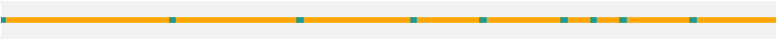

Fraction of total elements active in the ROM: 2.0%
residual = 1.1058230701978886e-14


In [19]:
plot(np.arange(d.ncells[0]), xi, ax="").element_()
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")
print(f"residual = {residual}")

### Specifiy the subtracted mean

In [20]:
Data_cls.mean = NLS_train_mean


### ROM Simulation

In [21]:
eval_rom = True

if eval_rom:
    ROM_h = ROM_simulation(Data_cls, NLS_test, param_list, test_mask, V_sel, xi=xi) #, N_rom_snap=1)
    ROM_h.run_simulation_h_ecsw()

In [22]:
if eval_rom:
    ROM = ROM_simulation(Data_cls, NLS_test, param_list, test_mask, V_sel) #, N_rom_snap=1)
    ROM.run_simulation()

### Performance Statistics

In [23]:
NLS_rom_h = np.asarray(ROM_h.NL_solutions_rom)
ROM_speed_up_h = ROM_h.speed_up_h
ROM_relative_error_h = ROM_h.rom_error

In [24]:
NLS_rom = np.asarray(ROM.NL_solutions_rom)
ROM_speed_up = ROM.speed_up
ROM_relative_error = ROM.rom_error

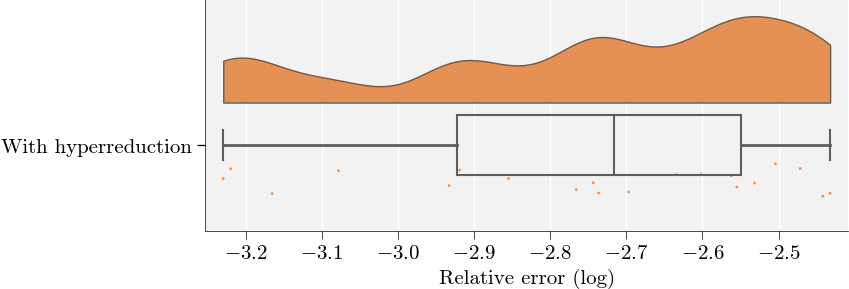

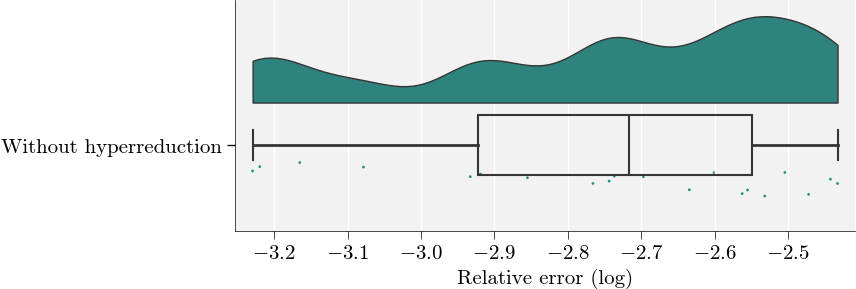

In [25]:
df_A = pd.DataFrame({'':'With hyperreduction','Relative error (log)':np.log10(ROM_relative_error_h)})
df_B = pd.DataFrame({'':'Without hyperreduction','Relative error (log)':np.log10(ROM_relative_error)})

# Combine the DataFrames
df = pd.concat([df_A, df_B])

fig, ax = plt.subplots(figsize=(8.3, 3))
pt.RainCloud(x = '', y = 'Relative error (log)', data = df_A, palette = "Oranges", bw = 0.2,
    width_viol = 1., ax = ax, orient = "h",pointplot = False, dodge=False, alpha=1.0, width_box = 0.35, linewidth=1, point_size =2.0, move=0.2)
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
pt.RainCloud(x = '', y = 'Relative error (log)', data = df_B, palette = "viridis", bw = 0.2,
    width_viol = 1., ax = ax, orient = "h",pointplot = False, dodge=False, alpha=1.0, width_box = 0.35, linewidth=1, point_size =2.0, move=0.2)
plt.show()

# ===

# df_C = pd.DataFrame({'':'With hyperreduction','Speed-up':ROM_speed_up_h})
# df_D = pd.DataFrame({'':'Without hyperreduction','Speed-up':ROM_speed_up})

# # Combine the DataFrames
# df2 = pd.concat([df_C, df_D])

# fig, ax = plt.subplots(figsize=(8.3, 2))
# pt.RainCloud(x = '', y = 'Speed-up', data = df_C, palette = "Oranges",
#     width_viol = 1.0, ax = ax, orient = "h",pointplot = False, dodge=True, alpha=1.0, width_box = 0.25, linewidth=1, point_size =2.0)

# fig, ax = plt.subplots(figsize=(8, 2))
# pt.RainCloud(x = '', y = 'Speed-up', data = df_D, palette = "viridis",
#     width_viol = 1.0, ax = ax, orient = "h",pointplot = False, dodge=True, alpha=0.95, width_box = 0.25, linewidth=1, point_size =2.0)
# plt.show()

In [26]:
# data_stats(ROM_speed_up_h, show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Speed-up", ylabel="Frequency");
# data_stats(np.log10(ROM_relative_error_h), show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Relative error (log)", ylabel="Frequency");

In [27]:
# data_stats(ROM_speed_up, show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Speed-up", ylabel="Frequency");
# data_stats(np.log10(ROM_relative_error), show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Relative error (log)", ylabel="Frequency");